# Import Libraries & Data

In [1]:
# Import Required Libraries

import pandas as pd  # For data manipulation
import nibabel as nib  # For loading fMRI data
from nilearn import plotting, image, glm  # For fMRI data analysis and visualization
import numpy as np  # For numerical operations

## Load Event Data (ArchiSpatial)
Load the event data from the _events.tsv file using pandas.

In [ ]:
### Here examplary subject 1 and session 0 - Archi spatial (ap)
events_file_path = '/Users/hannahmueller/nyx_fs/ibc_data/example_data/sub-01_ses-00_task-ArchiSpatial_dir-ap_events.tsv'

# Load the event data using pandas
events_data = pd.read_csv(events_file_path, sep='\t')

# Display the first few rows of the event data to verify it has been loaded correctly
events_data.head()

,onset,duration,trial_type
0,0.017,6.3,rotation_side
1,14.046,6.3,saccade
2,26.088,6.3,object_orientation
3,36.125,6.3,rotation_hand
4,44.175,6.3,object_grasp


## Extract Task Conditions

In [5]:
# Preprocess Event Data

# Extract different conditions of the task from the event data
conditions = events_data['trial_type'].unique()

# Create a dictionary to store the onset times for each condition
condition_onsets = {condition: events_data[events_data['trial_type'] == condition]['onset'].values for condition in conditions}

# Display the extracted conditions and their corresponding onset times
condition_onsets

{'rotation_side': array([1.70000e-02, 5.22250e+01, 1.12400e+02, 1.54487e+02, 2.86845e+02,
        3.18945e+02, 4.43186e+02, 4.57198e+02]),
 'saccade': array([ 14.046,  78.296, 140.442, 202.637, 296.866, 306.903, 419.153,
        469.224]),
 'object_orientation': array([ 26.088,  90.321, 124.426, 224.667, 274.803, 328.966, 365.04 ,
        429.173]),
 'rotation_hand': array([ 36.125, 100.359, 170.521, 194.587, 260.774, 338.986, 351.011,
        395.086]),
 'object_grasp': array([ 44.175,  66.254, 182.545, 212.658, 236.692, 244.741, 379.069,
        407.111])}

## Load fMRI data


<class 'nibabel.nifti1.Nifti1Image'>
data shape (105, 127, 105, 139)
affine:
[[  -1.5    0.     0.    78. ]
 [   0.     1.5    0.  -112. ]
 [   0.     0.     1.5  -70. ]
 [   0.     0.     0.     1. ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  4 105 127 105 139   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   1.5  1.5  1.5  0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : n

/Users/hannahmueller/Library/Python/3.9/lib/python/site-packages/nilearn/plotting/img_plotting.py:232: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(img, ensure_finite=True)


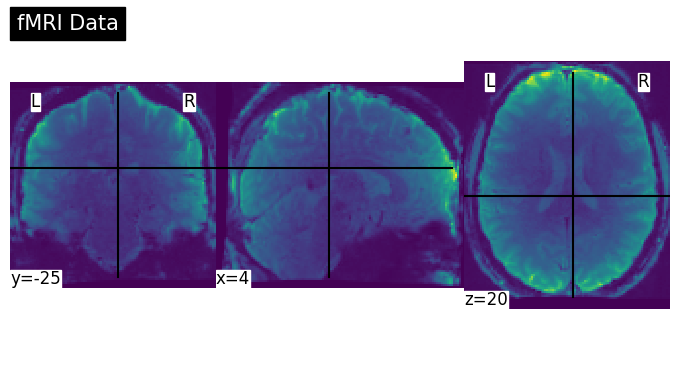

In [9]:
# Load fMRI Data

# Define the path to the fMRI data file
fmri_file_path = '/Users/hannahmueller/nyx_fs/ibc_data/example_data/wrdcsub-01_ses-03_task-HcpEmotion_acq-pa_bold.nii'

# Load the fMRI data using nibabel
fmri_img = nib.load(fmri_file_path)

# Display basic information about the fMRI data
print(fmri_img)

# Select the first volume (3D) from the 4D fMRI data
fmri_img_3d = image.index_img(fmri_img, 0)

# Plot the 3D fMRI data to visualize it
plotting.plot_img(fmri_img_3d, title="fMRI Data")

# Design Matrix

In [ ]:
# Design Matrix Creation

from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

# Define the repetition time (TR) of the fMRI data
tr = 2.0  # Example TR, replace with the actual TR of your fMRI data

# Define the frame times based on the number of volumes and TR
n_scans = fmri_img.shape[-1]
frame_times = np.arange(n_scans) * tr

# Create the design matrix using the condition onsets
design_matrix = make_first_level_design_matrix(frame_times, condition_onsets)

# Display the design matrix
plot_design_matrix(design_matrix)
plt.show()

# Display the first few rows of the design matrix
design_matrix.head()

# Fit GLM Model
Fit the GLM model to the fMRI data using nilearn's GLM functions.

In [ ]:
from nilearn.glm.first_level import FirstLevelModel

# Fit GLM Model

# Initialize the GLM model
glm_model = FirstLevelModel(t_r=tr, slice_time_ref=0.5, hrf_model='spm')

# Fit the GLM model to the fMRI data using the design matrix
glm_model = glm_model.fit(fmri_img, design_matrices=design_matrix)

# Display the summary of the fitted model
glm_model

# Visualize Results

In [ ]:
# Visualize Results

# Compute the contrast for each condition
from nilearn.glm.contrasts import compute_contrast

# Define the contrast for each condition (e.g., condition vs. baseline)
contrasts = {condition: np.eye(len(conditions))[i] for i, condition in enumerate(conditions)}

# Compute the contrast maps
contrast_maps = {condition: glm_model.compute_contrast(contrasts[condition], output_type='z_score') for condition in conditions}

# Plot the contrast maps
for condition, contrast_map in contrast_maps.items():
    plotting.plot_stat_map(contrast_map, title=f'Contrast Map: {condition}', threshold=3.0, display_mode='z', cut_coords=10)
    plotting.show()

# Display the activation patterns for each condition
for condition, contrast_map in contrast_maps.items():
    plotting.plot_glass_brain(contrast_map, title=f'Activation Pattern: {condition}', threshold=3.0, display_mode='lyrz')
    plotting.show()